# Baseline setup

## Load Data

## Resnet or some other model that might be a better base for hierarchical classification

### One classification head first
Start with one classification head that tries to predict all 3(4?) classes at once

### N classification heads

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import time
import copy

In [12]:
# Configuration
# The Stanford Cars dataset has 196 classes
NUM_CLASSES = 196
BATCH_SIZE = 32
NUM_EPOCHS = 15 
LEARNING_RATE = 0.001

# Standard ImageNet normalization parameters for ResNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224 # Standard input size for ResNet

# IMPORTANT: Set your dataset root path here!
DATA_ROOT = './data'

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available and device is set")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available and device is set")
else:
    device = torch.device("cpu")
    print("No device is available device set to cpu")

print(f"Using device: {device}")

No device is available device set to cpu
Using device: cpu


In [17]:
# --- DATA PREPROCESSING ---
from sklearn.model_selection import train_test_split

# Only resizing and ImageNet normalization, no random operations.
data_transforms = transforms.Compose([
    transforms.Resize(256),              # 1. Standardize image size
    transforms.CenterCrop(IMAGE_SIZE),   # 2. Crop to ResNet's input size (224x224)
    transforms.ToTensor(),               # 3. Convert to PyTorch Tensor
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD) # 4. ImageNet Normalization
])

try:
    # Load the full training dataset
    full_train_dataset = datasets.StanfordCars(root=DATA_ROOT, download=False, split="train", transform=data_transforms)
    test_dataset = datasets.StanfordCars(root=DATA_ROOT, download=False, split="test", transform=data_transforms)
    #full_train_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, 'cars_train'), data_transforms)
    #test_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, 'cars_test'), data_transforms)
    
    # Get the list of all labels in the full training dataset
    all_labels = [label for _, label in full_train_dataset]
    
    # Split the dataset using stratified sampling (80/20 split)
    train_indices, val_indices = train_test_split(
        list(range(len(full_train_dataset))),
        test_size=0.2,  # 80/20 split
        stratify=all_labels,  # Stratified split to preserve label distribution
        random_state=42
    )
    
    # Create subsets based on the indices
    train_subset = torch.utils.data.Subset(full_train_dataset, train_indices)
    val_subset = torch.utils.data.Subset(full_train_dataset, val_indices)
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Store the DataLoaders and dataset sizes
    dataloaders = {'train': train_loader, 'val': val_loader}
    dataset_sizes = {'train': len(train_subset), 'val': len(val_subset)}

    # Class names and indexing for the StanfordCars dataset
    class_names = full_train_dataset.classes
    idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}


except FileNotFoundError as e:
    print(f"\n[ERROR] Data not found. Please check your DATA_ROOT path: {DATA_ROOT}")
    print("Ensure you have 'train' and 'test' subdirectories with images inside.")

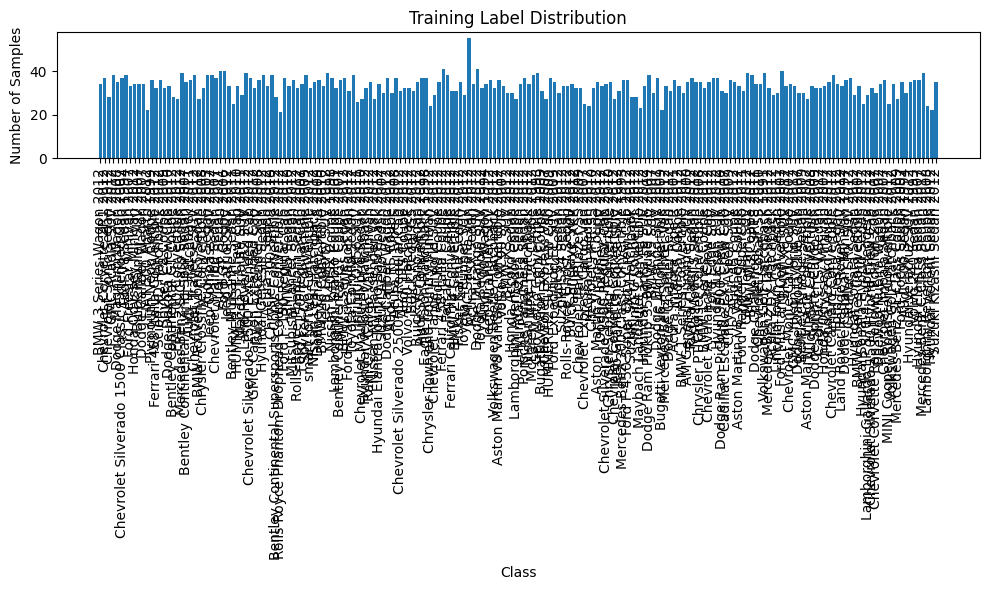

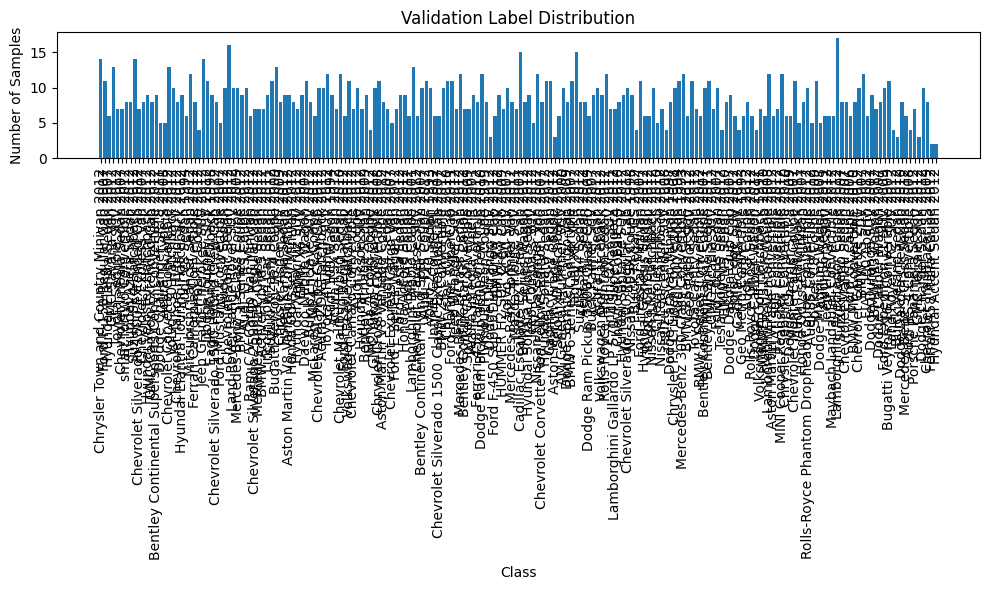

In [20]:
# --- CHECK IF LABELS ARE BALANCED ---

from collections import Counter
import matplotlib.pyplot as plt

# TRAINING DATASET
# Get the labels from the training dataset
train_labels = [label for _, label in train_dataset]

# Count the occurrences of each class label
train_label_counts = Counter(train_labels)

# Get class names corresponding to the indices
class_names = [idx_to_class[class_idx] for class_idx in train_label_counts.keys()]
counts = list(train_label_counts.values())

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Training Label Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# VALIDATION DATASET
# Get the labels from the validation dataset
val_labels = [label for _, label in val_dataset]

# Count the occurrences of each class label
val_label_counts = Counter(val_labels)

# Get class names corresponding to the indices
val_class_names = [idx_to_class[class_idx] for class_idx in val_label_counts.keys()]
val_counts = list(val_label_counts.values())

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(val_class_names, val_counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Validation Label Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [14]:
# --- MODEL SETUP (ResNet-50 Feature Extractor) ---

def setup_resnet_baseline(num_classes):
    # 1. Load Pretrained ResNet-50
    # Use the default ImageNet weights
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # 2. Freeze all convolutional layers (Feature Extraction)
    # This is the "Transfer Learning" step. Only the final classification head will learn.
    for param in model.parameters():
        param.requires_grad = False

    # 3. Replace the final Fully Connected layer (the "Head")
    # Get the input feature size of the original FC layer (2048 for ResNet-50)
    num_ftrs = model.fc.in_features

    # Map the features to the new number of classes (196)
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    # NOTE: Only model.fc's parameters are now set to requires_grad=True
    return model

model_baseline = setup_resnet_baseline(NUM_CLASSES)
if device == torch.device("mps"):
    model_baseline.float()
model_baseline.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()

# Only pass the parameters of the un-frozen layers (the new 'fc' layer)
optimizer = optim.Adam(model_baseline.fc.parameters(), lr=LEARNING_RATE)

In [25]:
from experiment_logging import ExperimentLogger

logger = ExperimentLogger(
    log_file="experiment_log.md",
    active=True,         # set False to disable logging
    show_console=True    # preview logs in notebook
)

# Base info for this experiment
logger.set(
    name="Name of experiment",
    changes="Changes",
    reason="Improve generalization and convergence speed"
)

In [26]:
def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS):

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store epoch metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print("Starting Training...")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Compute epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save losses & accuracies for plotting later
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

                # Log validation metrics (1 per epoch)
                logger.record_metrics(
                    epoch=epoch + 1,
                    train_loss=train_losses[-1],
                    train_acc=train_accs[-1],
                    val_loss=val_losses[-1],
                    val_acc=val_accs[-1]
                )

            # Update best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    # ------------------------------------------------------
    # END OF TRAINING LOOP — NOW LOG PLOTS AND RESULTS
    # ------------------------------------------------------

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)

    # ------------------------------------------------------
    # Plot Loss Curve
    # ------------------------------------------------------
    fig, ax = plt.subplots()
    ax.plot(train_losses, label="train_loss")
    ax.plot(val_losses, label="val_loss")
    ax.set_title("Loss Curve")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    logger.add_plot(fig, name="loss_curve")

    # ------------------------------------------------------
    # Plot Accuracy Curve
    # ------------------------------------------------------
    fig2, ax2 = plt.subplots()
    ax2.plot(train_accs, label="train_acc")
    ax2.plot(val_accs, label="val_acc")
    ax2.set_title("Accuracy Curve")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    logger.add_plot(fig2, name="accuracy_curve")

    # ------------------------------------------------------
    # Confusion Matrix (validation dataset)
    # ------------------------------------------------------
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders["val"]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(all_labels, all_preds)

    logger.add_confusion_matrix(cm, class_names=class_names)

    # ------------------------------------------------------
    #  Save a sample validation image
    # ------------------------------------------------------
    sample_img, _ = next(iter(dataloaders["val"]))
    logger.add_image(sample_img[0], name="sample_val_image")

    # ------------------------------------------------------
    #  Write final notes + results to log
    # ------------------------------------------------------
    logger.results = f"Best Validation Accuracy = {best_acc:.4f}"
    logger.notes = "Training completed successfully. Loss/accuracy plots and confusion matrix logged."

    logger.commit()

    # ------------------------------------------------------
    #  Save trained model checkpoint
    # ------------------------------------------------------
    model_path = f"models/{logger.name}_best.pth"
    os.makedirs("models", exist_ok=True)

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": num_epochs,
        "best_acc": best_acc.item() if hasattr(best_acc, "item") else float(best_acc)
    }, model_path)

    print(f"🔒 Saved trained model to {model_path}")

    return model


In [27]:
def check_setup():
    print("\n--- Running Setup Health Check ---")
    
    # 1. Device check (already done, but reconfirm)
    print(f"Model is on: {next(model_baseline.parameters()).device}")
    
    # 2. Data Loader Check (load a single batch)
    try:
        inputs, labels = next(iter(train_loader))
        
        # 3. Check for float32 enforcement and device transfer
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device)
        
        # Check input tensor properties
        print(f"Input batch shape: {inputs.shape}")
        print(f"Input tensor dtype: {inputs.dtype}")
        print(f"Input tensor device: {inputs.device}")
        
    except Exception as e:
        print(f"[CRITICAL ERROR] Failed to load or transfer batch. Fix this before training.")
        print(f"Error details: {e}")
        return

    # 4. Model Forward Pass Check
    try:
        model_baseline.eval() # Set to eval mode for the check
        with torch.no_grad():
            outputs = model_baseline(inputs)
            
        print(f"Output shape (Batch x Classes): {outputs.shape}")
        print("Setup check PASSED! Ready for full training.")
        
    except Exception as e:
        print(f"[CRITICAL ERROR] Failed during forward pass.")
        print(f"Error details: {e}")

# check_setup() # Run this once before calling train_model

In [28]:

# To run the training:
check_setup()
final_baseline_model = train_model(model_baseline, criterion, optimizer, num_epochs=NUM_EPOCHS)


--- Running Setup Health Check ---
Model is on: cpu
Input batch shape: torch.Size([32, 3, 224, 224])
Input tensor dtype: torch.float32
Input tensor device: cpu
Output shape (Batch x Classes): torch.Size([32, 196])
Setup check PASSED! Ready for full training.
Starting Training...

Epoch 1/1
--------------------
train Loss: 4.7268 Acc: 0.0935
val   Loss: 4.1846 Acc: 0.1657

Training complete in 10m 34s
Best validation Acc: 0.1657


ValueError: Floating point image RGB values must be in the 0..1 range.

In [ ]:
def evaluate_model(model, loader, dataset_size, device):
    print("\n--- Starting Test Set Evaluation ---")
    
    model.eval() # Set model to evaluation mode
    running_corrects = 0
    
    # Top-5 accuracy tracking
    top5_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in loader:
            
            # Ensure consistent device and dtype (float32)
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            # --- Top-1 Accuracy ---
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
            # --- Top-5 Accuracy (Good for Fine-Grained Tasks) ---
            # Get the top 5 predicted classes
            _, top5_preds = torch.topk(outputs, 5, dim=1)
            
            # Check if the true label is in the top 5 predictions
            labels_reshaped = labels.view(-1, 1) # Shape [Batch, 1]
            top5_corrects += torch.sum(top5_preds.eq(labels_reshaped)).item()
            total_samples += inputs.size(0)

    # Calculate final metrics
    if device != torch.device("mps"):
        top1_acc = running_corrects.double() / dataset_size
    else:
        top1_acc = running_corrects.float() / dataset_size
    top5_acc = top5_corrects / total_samples
    
    print(f'Test Set Size: {dataset_size}')
    print(f'Final Baseline Top-1 Accuracy: {top1_acc.item():.4f}')
    print(f'Final Baseline Top-5 Accuracy: {top5_acc:.4f}')
    
    return top1_acc.item(), top5_acc

# --- Example of running the test ---

# 1. Load the best weights saved during training
best_model_test = setup_resnet_baseline(NUM_CLASSES)
best_model_test.to(device).float() # Ensure float32 and device transfer
# best_model_test.load_state_dict(torch.load('best_baseline_weights.pth', map_location=device))

# 2. Run the evaluation
test_top1_acc, test_top5_acc = evaluate_model(final_baseline_model, test_loader, len(test_dataset), device)


--- Starting Test Set Evaluation ---
Test Set Size: 8041
Final Baseline Top-1 Accuracy: 0.4279
Final Baseline Top-5 Accuracy: 0.6933


In [34]:
import torch
import numpy as np

def get_predictions_and_labels(model, loader, device):
    """
    Runs the model on the data loader and collects all predictions, 
    true labels, and output logits.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for inputs, labels in loader:
            # Ensure consistent device and dtype (float32)
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device)

            outputs = model(inputs)
            
            # Get Top-1 prediction index
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_outputs)

# Example usage (assuming 'best_model_test', 'test_loader', 'device' are defined):
test_preds, test_labels, test_outputs = get_predictions_and_labels(
    final_baseline_model, test_loader, device)


In [35]:
class_names = full_train_dataset.classes
idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

In [ ]:
# 1. Find indices where prediction does not match label
incorrect_indices = np.where(test_preds != test_labels)[0]

# 2. Total errors should match (1 - Accuracy)
num_incorrect = len(incorrect_indices)
print(f"Total Incorrect Predictions: {num_incorrect}")
print(f"Total Test Samples: {len(test_labels)}")
print(f"Error Rate (Expected): {1 - 0.8832:.4f} vs Actual: {num_incorrect / len(test_labels):.4f}")

# 3. Print a few specific errors to check for patterns
# Print a few specific errors to check for patterns
for i, idx in enumerate(incorrect_indices[:5]):
    predicted_class_idx = test_preds[idx]
    true_class_idx = test_labels[idx]
    
    # Map the indices to their human-readable names
    predicted_class_name = idx_to_class[predicted_class_idx]
    true_class_name = idx_to_class[true_class_idx]
    
    print(f"\nError #{i+1} (Index {idx}):")
    print(f"  Predicted Class: **{predicted_class_name}**")
    print(f"  True Class:      **{true_class_name}**")

Total Incorrect Predictions: 4600
Total Test Samples: 8041
Error Rate (Expected): 0.1168 vs Actual: 0.5721

Error #1 (Index 0):
  Predicted Class: **BMW X6 SUV 2012**
  True Class:      **Suzuki Aerio Sedan 2007**

Error #2 (Index 4):
  Predicted Class: **Spyker C8 Convertible 2009**
  True Class:      **Tesla Model S Sedan 2012**

Error #3 (Index 5):
  Predicted Class: **Ford Expedition EL SUV 2009**
  True Class:      **Chrysler Town and Country Minivan 2012**

Error #4 (Index 6):
  Predicted Class: **Rolls-Royce Ghost Sedan 2012**
  True Class:      **GMC Terrain SUV 2012**

Error #5 (Index 7):
  Predicted Class: **Hyundai Genesis Sedan 2012**
  True Class:      **Mercedes-Benz S-Class Sedan 2012**
